# Equação de Onda 1D

Vamos resolver numericamente a equação de onda a 1D:

\begin{align*}
\frac{\partial ^2u}{\partial t^2} = v^2\frac{\partial^2u}{\partial x^2}
\end{align*}

# Imports

In [142]:
# Importar as bibliotecas que vamos usar
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter

from PIL import Image
from typing import Callable

# Método CTCS

In [143]:
def onda1DCTCS(T: float, fi: np.ndarray, gi: np.ndarray, mask: np.ndarray, v: float, dx: float, C: float = 1.0, periodic: bool = False, save: bool = False) -> tuple[np.ndarray, float]:
    """
        Resolve a equação de onda de forma aproximada usando o método CTCS!

        :param T: float, Tempo para evoluir a equação
        :param fi: np.ndarray, array com as condições iniciais
        :param gi: np.ndarray, array com as condições iniciais para a derivada
        :param mask: np.ndarray, evolui apenas os pontos onde `mask == True` e usa `mask[0]`/ `mask[-1]` para determinar se os extremos esquerdo/ direito são fechados (caso `False`) ou abertos (caso `True`)
        :param v: float, velocidade no meio
        :param dx: float, espaçamento entre pontos no eixo dos xx
        :param C: float, número de Courant
        :param periodic: bool, se for `True` usamos condição fronteira periódicas
        :param save: bool, se for `True` guardamos o estado em todos os frames

        :return: tuple containing:
            - np.ndarray, vetor solução
            - float, tempo decorrido
    """

    # Copiar condições iniciais
    pre = np.copy(fi)
    now = np.copy(fi)
    nex = np.copy(fi)

    total = []
    if save:
        total = [list(np.copy(fi))]

    # Condições de extremo aberto
    openL = mask[0]
    openR = mask[-1]

    # Criar o passo no tempo
    dt = C * dx / v
    iMax = T // dt + 1

    # Evoluir no tempo
    i = 0
    while i < iMax:
        # Arrays para condição de fronteira periódicas
        left = np.concatenate((now[-1:], now[:-1]))
        righ = np.concatenate((now[1:], now[0:1]))
        
        # Alterar para condição extremo aberto
        if not periodic:
            if openL:
                left[0] = now[1]
            if openR:
                righ[-1] = now[-2]
        

        # Aplicar a condição inicial na derivada
        if i == 0:
            nex = nex + mask * (dt * gi + (1-C**2) * now + C**2 * (righ + left) / 2 - nex)
        
        # Dar um passo normal
        else:
            nex = nex + mask * (-1 * pre + 2 * (1-C**2) * now + C**2 * (righ + left) - nex)
        
        
        # Avançar para a próxima iteração
        i += 1
        pre = np.copy(now)
        now = np.copy(nex)

        if save:
            total += [list(np.copy(now))]
    
    # Devolver todos os estados
    if save:
        return np.array(total), dt
    
    return now, i * dt

# Testar

## Caso 1 - Extremos Fechados

Vamos considerar a solução em modo normal da equação de onda:

$$
u(x, t) = \sin\left(k_nx\right)\cos(\omega_n t)
$$

Temos então as seguintes condições iniciais:
$$
\begin{align*}
u(x, 0) &= \sin\left(k_nx\right)
\\\\

u'(x, 0) &= 0
\end{align*}
$$


In [144]:
# Parâmetros
Tmax = 2

Lx = 1
v = 1

Nx = 150
dx = Lx / (Nx - 1)

n = 1
k = n * np.pi / Lx
omega = k * v


# Domínio
xx = np.linspace(0, Lx, Nx)

# Condições fronteira extremo fechado
mask = np.full_like(xx, True)
mask[0] = False
mask[-1] = False


# Solução
A = 1
def u(x, t):
    return A * np.sin(k * x) * np.cos(omega * t)


fi = u(xx, 0)
gi = np.zeros_like(fi)

### Método CTCS

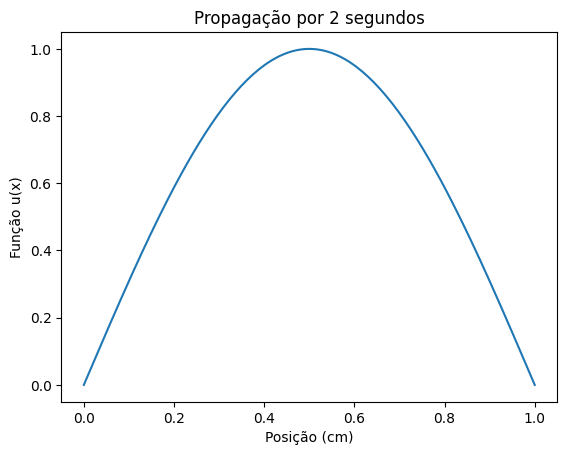

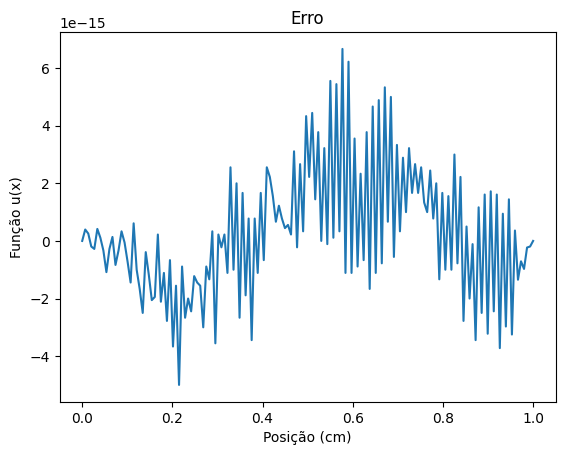

MovieWriter ffmpeg unavailable; using Pillow instead.


In [145]:
# Fazer a simulação
sol, dt = onda1DCTCS(Tmax, fi, gi, mask, v, dx, save=True)

# Mostrar a solução
plt.plot(xx, sol[-1], label="Resultado")
plt.title(f"Propagação por {dt * (len(sol) - 1):.0f} segundos")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()

# Comparar com a solução exata
plt.plot(xx, sol[-1] - u(xx, dt * (len(sol) - 1)), label="Resultado")
plt.title(f"Erro")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()


# Inicializar o Vídeo!
fig, ax = plt.subplots()
line, = ax.plot(xx, sol[0])
if n == 1:
    ax.set_ylim(-A * 1.04, A * 1.04)


# Velocidade
videoS = 1

# Função de inicialização
def init():
    plt.title(f"Propagação por 0 segundos")
    plt.xlabel('Posição (m)')
    plt.ylabel('Função u(x)')
    line.set_ydata(sol[0])
    return line,

# Função de atualização
def update(frame):
    index =  frame * videoS

    plt.title(f"Propagação por {dt * index:.2f} segundos")
    line.set_ydata(sol[index])
    return line,

# Criar a animação
ani = animation.FuncAnimation(fig, update, frames=np.arange(0, len(sol) // videoS), init_func=init, blit=True, interval=50)
ani.save('animation1.gif', writer='ffmpeg', fps=20)
plt.close()

## Caso 2 - Extremos Abertos

Vamos considerar a solução em modo normal da equação de onda:

$$
u(x, t) = \cos\left(k_nx\right)\cos(\omega_n t)
$$

Temos então as seguintes condições iniciais:
$$
\begin{align*}
u(x, 0) &= \sin\left(k_nx\right)
\\\\

u'(x, 0) &= 0
\end{align*}
$$

In [146]:
# Parâmetros
Tmax = 2

Lx = 1
v = 1

Nx = 150
dx = Lx / (Nx - 1)

n = 2
k = n * np.pi / Lx
omega = k * v


# Domínio
xx = np.linspace(0, Lx, Nx)

# Condições fronteira extremo fechado
mask = np.full_like(xx, True)


# Solução
A = 1
def u(x, t):
    return A * np.cos(k * x) * np.cos(omega * t)


fi = u(xx, 0)
gi = np.zeros_like(fi)

### Método CTCS

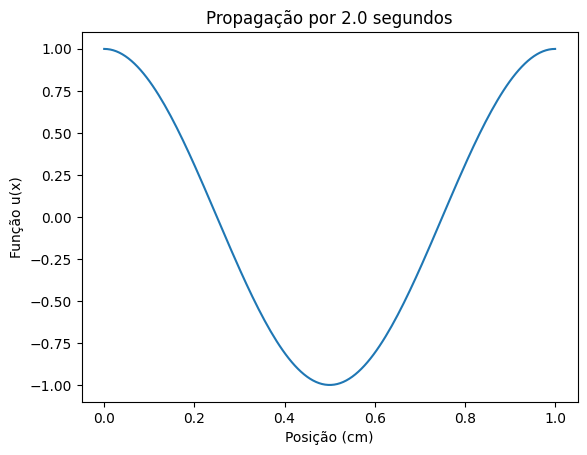

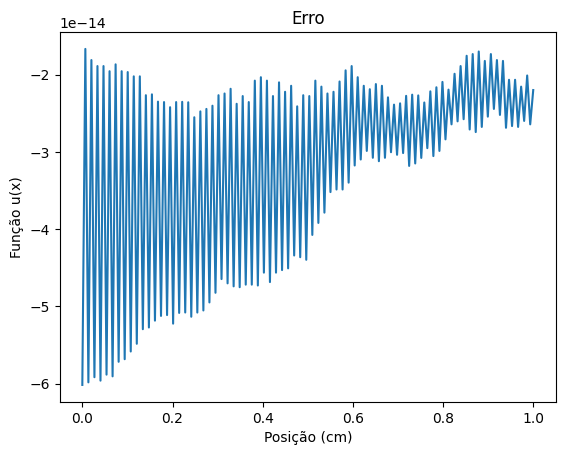

MovieWriter ffmpeg unavailable; using Pillow instead.


In [147]:
# Fazer a simulação
sol, dt = onda1DCTCS(Tmax, fi, gi, mask, v, dx, save=True)

# Mostrar a solução
plt.plot(xx, sol[-1], label="Resultado")
plt.title(f"Propagação por {dt * (len(sol) - 1):.1f} segundos")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()

# Comparar com a solução exata
plt.plot(xx, sol[-1] - u(xx, dt * (len(sol) - 1)), label="Resultado")
plt.title(f"Erro")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()


# Inicializar o Vídeo!
fig, ax = plt.subplots()
line, = ax.plot(xx, sol[0])
if n == 1:
    ax.set_ylim(-A * 1.04, A * 1.04)


# Velocidade
videoS = 1

# Função de inicialização
def init():
    plt.title(f"Propagação por 0 segundos")
    plt.xlabel('Posição (m)')
    plt.ylabel('Função u(x)')
    line.set_ydata(sol[0])
    return line,

# Função de atualização
def update(frame):
    index =  frame * videoS

    plt.title(f"Propagação por {dt * index:.2f} segundos")
    line.set_ydata(sol[index])
    return line,

# Criar a animação
ani = animation.FuncAnimation(fig, update, frames=np.arange(0, len(sol) // videoS), init_func=init, blit=True, interval=50)
ani.save('animation2.gif', writer='ffmpeg', fps=20)
plt.close()

## Caso 3 - Fronteira Perióica

Vamos considerar a solução em onda propagante da equação de onda:

$$
u(x, t) = f(x - vt)
$$

Temos então as seguintes condições iniciais:
$$
\begin{align*}
u(x, 0) &= f(x)
\\\\

u'(x, 0) &= -vf'(x)
\end{align*}
$$

In [148]:
# Parâmetros
Tmax = 2

Lx = 5
v = 1

Nx = 550
dx = Lx / (Nx - 1)

# Domínio
xx = np.linspace(-Lx/2, Lx/2, Nx)

# Condições fronteira não interessam
mask = np.full_like(xx, True)


# Solução
def f(x):
    return np.exp(-x**2)

def fprime(x):
    return np.exp(-x**2) * (-2 * x)

def u(x, t):
    return f(x - v * t)


fi = u(xx, 0)
gi = -v * fprime(xx)

### Método CTCS

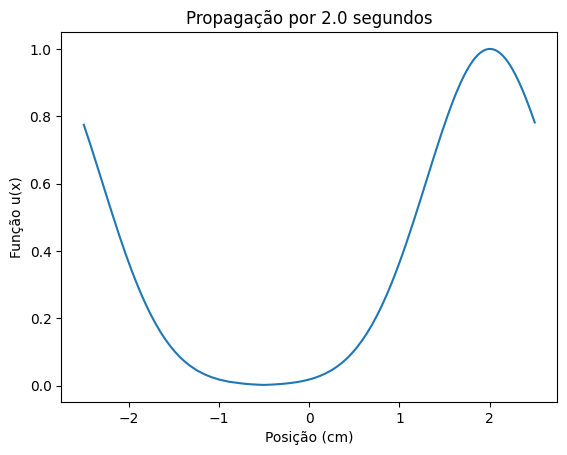

MovieWriter ffmpeg unavailable; using Pillow instead.


In [149]:
# Fazer a simulação
sol, dt = onda1DCTCS(Tmax, fi, gi, mask, v, dx, periodic=True, save=True)

# Mostrar a solução
plt.plot(xx, sol[-1], label="Resultado")
plt.title(f"Propagação por {dt * (len(sol) - 1):.1f} segundos")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()


# Inicializar o Vídeo!
fig, ax = plt.subplots()
line, = ax.plot(xx, sol[0])


# Velocidade
videoS = 4

# Função de inicialização
def init():
    plt.title(f"Propagação por 0 segundos")
    plt.xlabel('Posição (m)')
    plt.ylabel('Função u(x)')
    line.set_ydata(sol[0])
    return line,

# Função de atualização
def update(frame):
    index =  frame * videoS

    plt.title(f"Propagação por {dt * index:.2f} segundos")
    line.set_ydata(sol[index])
    return line,

# Criar a animação
ani = animation.FuncAnimation(fig, update, frames=np.arange(0, len(sol) // videoS), init_func=init, blit=True, interval=50)
ani.save('animation3.gif', writer='ffmpeg', fps=20)
plt.close()

# Experimentar

## Caso 1 - Reflexão em extremo aberto/ fechado

In [150]:
# Parâmetros
Tmax = 20

Lx = 10
v = 1

Nx = 550
dx = Lx / (Nx - 1)

# Domínio
xx = np.linspace(-Lx/2, Lx/2, Nx)

# Condições fronteira de extremo fechado num lado e aberto noutro
mask = np.full_like(xx, True)
mask[-1] = False


# Solução
def f(x):
    return np.exp(-x**2)

def fprime(x):
    return np.exp(-x**2) * (-2 * x)

def u(x, t):
    return f(x - v * t)


fi = u(xx, 0)
gi = -v * fprime(xx)

### Método CTCS

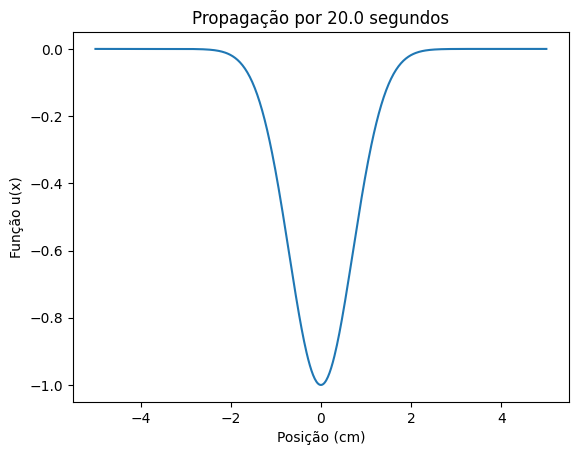

MovieWriter ffmpeg unavailable; using Pillow instead.


In [151]:
# Fazer a simulação
sol, dt = onda1DCTCS(Tmax, fi, gi, mask, v, dx, save=True)

# Mostrar a solução
plt.plot(xx, sol[-1], label="Resultado")
plt.title(f"Propagação por {dt * (len(sol) - 1):.1f} segundos")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()


# Inicializar o Vídeo!
fig, ax = plt.subplots()
line, = ax.plot(xx, sol[0])
ax.set_ylim(-np.max(np.abs(fi)) * 2.04, np.max(np.abs(fi)) * 2.04)

# Velocidade
videoS = 4

# Função de inicialização
def init():
    plt.title(f"Propagação por 0 segundos")
    plt.xlabel('Posição (m)')
    plt.ylabel('Função u(x)')
    line.set_ydata(sol[0])
    return line,

# Função de atualização
def update(frame):
    index =  frame * videoS

    plt.title(f"Propagação por {dt * index:.2f} segundos")
    line.set_ydata(sol[index])
    return line,

# Criar a animação
ani = animation.FuncAnimation(fig, update, frames=np.arange(0, len(sol) // videoS), init_func=init, blit=True, interval=50)
ani.save('animation.gif', writer='ffmpeg', fps=20)
plt.close()